# EDA 

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline


Import data

In [45]:
cars = pd.read_csv('data/cars.csv', encoding = 'utf-8', encoding_errors='ignore')
cars.head()

,Unnamed: 0,name,link,price,mileage,BHP,transmission,fuel,owners,body,ULEZ,engine,year,filename,car model
0,0,Vauxhall Astra,https://www.autotrader.co.uk/car-details/20220...,£995,85405.0,103.0,Manual,Petrol,4.0,Hatchback,ULEZ,1.6L,2005 (55 reg),data\Vauxhall_Astra.txt,data\Vauxhall_Astra
1,1,Vauxhall Astra,https://www.autotrader.co.uk/car-details/20220...,"£1,350",84000.0,103.0,Manual,Petrol,3.0,Hatchback,ULEZ,1.6L,2005 (55 reg),data\Vauxhall_Astra.txt,data\Vauxhall_Astra
2,2,Vauxhall Astra,https://www.autotrader.co.uk/car-details/20220...,"£1,100",105000.0,79.0,Manual,Diesel,NaN,Estate,NaN,1.7L,2005 (54 reg),data\Vauxhall_Astra.txt,data\Vauxhall_Astra
3,3,Vauxhall Astra,https://www.autotrader.co.uk/car-details/20220...,£998,NaN,79.0,Manual,Diesel,NaN,Estate,NaN,1.7L,2005 (05 reg),data\Vauxhall_Astra.txt,data\Vauxhall_Astra
4,4,Vauxhall Astra,https://www.autotrader.co.uk/car-details/20220...,"£1,695",64000.0,123.0,Automatic,Petrol,5.0,Estate,ULEZ,1.8L,2005 (55 reg),data\Vauxhall_Astra.txt,data\Vauxhall_Astra


Drop Unnamed column

In [46]:
cols_to_drop = ['Unnamed: 0','link','filename','car model']


for col in cols_to_drop:
    cars.drop(columns = [col], inplace = True)
    
cars.head()

,name,price,mileage,BHP,transmission,fuel,owners,body,ULEZ,engine,year
0,Vauxhall Astra,£995,85405.0,103.0,Manual,Petrol,4.0,Hatchback,ULEZ,1.6L,2005 (55 reg)
1,Vauxhall Astra,"£1,350",84000.0,103.0,Manual,Petrol,3.0,Hatchback,ULEZ,1.6L,2005 (55 reg)
2,Vauxhall Astra,"£1,100",105000.0,79.0,Manual,Diesel,NaN,Estate,NaN,1.7L,2005 (54 reg)
3,Vauxhall Astra,£998,NaN,79.0,Manual,Diesel,NaN,Estate,NaN,1.7L,2005 (05 reg)
4,Vauxhall Astra,"£1,695",64000.0,123.0,Automatic,Petrol,5.0,Estate,ULEZ,1.8L,2005 (55 reg)


Shape

In [47]:
cars.shape

(20623, 11)

Dtypes

In [48]:
cars.dtypes

name             object
price            object
mileage         float64
BHP             float64
transmission     object
fuel             object
owners          float64
body             object
ULEZ             object
engine           object
year             object
dtype: object

In [49]:
cars.isnull().sum()

name                0
price               0
mileage             4
BHP             13014
transmission        5
fuel                0
owners          13260
body                1
ULEZ             1858
engine            159
year              306
dtype: int64

Heatmap of Null Values

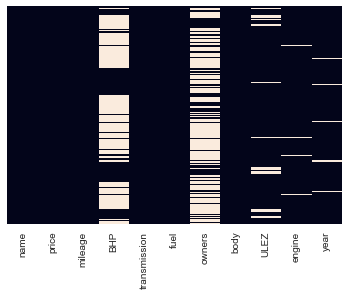

In [50]:
sns.heatmap(cars.isnull(),yticklabels=False,cbar=False)
plt.show()

Mode value of BHP for each car model

In [51]:
cars.groupby(['name'])['BHP'].agg(pd.Series.mode).to_frame().reset_index()

,name,BHP
0,Vauxhall ASX,89.0
1,Vauxhall Astra,113.0
2,Vauxhall Astra 1.0i Turbo ecoTEC SRi Nav Hatch...,[]
3,Vauxhall Astra Diesel Estate,[]
4,Vauxhall Astra Diesel Hatchback,[]
5,Vauxhall Astra Diesel Sports Toure,[]
6,Vauxhall Astra Gtc,276.0
7,Vauxhall Astra Hatchback,113.0
8,Vauxhall Astra Hatchback Special Eds,[]
9,Vauxhall Astra Sports Tourer,113.0


### Remove Rows

In [52]:

cars_to_drop = ['Gtc','Non-franchise']
for car in cars_to_drop:
    cars.drop(cars.index[cars['name'] == car], inplace = True)
cars.name.unique()

print(cars.shape)

(20623, 11)


Drop Rows with no previous owners

In [53]:
# filter used cars only
cars.drop(cars.index[cars['owners'].isnull()], inplace = True)
cars.shape

(7363, 11)

### Remove unwanted characters from Values

In [54]:
# Retrieving the name of the model
cars['name'] =  cars['name'].str.split(" ").str[1].str.capitalize()
cars['name']  = cars['name'].str.replace('Grandland','Grandland_x')

# Remove unwanted symbols from columns
cars['price']  = cars['price'].str.replace('£','')
cars['price'] = cars['price'].str.replace(',','')
cars['engine'] = cars['engine'].str.replace('L','')

# mapping ULEZ to Yes
cars['ULEZ'] = cars['ULEZ'].str.replace('ULEZ','Yes')

#renaming names
cars.loc[cars['name'].str.contains('Mokka x', na = False)] = cars['name'].str.replace('Mokka x','Mokka_x')

# changing format
cars['year'] = cars['year'].astype('str')



cars['year'] = cars['year'].str[:4]

cars.head(2)

,name,price,mileage,BHP,transmission,fuel,owners,body,ULEZ,engine,year
0,Astra,995,85405.0,103.0,Manual,Petrol,4.0,Hatchback,Yes,1.6,2005
1,Astra,1350,84000.0,103.0,Manual,Petrol,3.0,Hatchback,Yes,1.6,2005


Changing Datatypes

In [55]:

cars['price'] = cars['price'].astype('int')
cars['owners'] = cars['owners'].astype('int')
cars.engine = cars['engine'].astype('float')
cars.year = pd.to_numeric(cars.year, errors="coerce")

cars['ULEZ'] = cars['ULEZ'].fillna('No')



cars.dtypes

name             object
price             int32
mileage         float64
BHP             float64
transmission     object
fuel             object
owners            int32
body             object
ULEZ             object
engine          float64
year            float64
dtype: object

In [56]:
cars.isnull().sum()

name               0
price              0
mileage            2
BHP             3682
transmission       1
fuel               0
owners             0
body               0
ULEZ               0
engine            15
year             104
dtype: int64

### Costliest Car

In [57]:
highest_cost = cars[['name','price']].sort_values('price',ascending=False).head(10)
highest_cost.head()

,name,price
16839,Mokka,31500
14611,Grandland_x,28991
16858,Mokka,28000
14456,Grandland_x,27990
14599,Grandland_x,27499


In [58]:
cheapest_car = cars[['name','price']].sort_values('price',ascending=True).head(10)
cheapest_car.head()

,name,price
14740,Meriva,495
6996,Corsa,500
452,Astra,600
5897,Corsa,600
269,Astra,755


Function to plot barchart

In [59]:
def plot_bar_chart(df,x_col,y_col,title='',figsize=(10,5),palette='magma'):
        """
        function to plot charts 
        i/p : df,x_col,y_col 
        o/p : saves file in local directory
        
        """



        plt.figure(figsize = figsize) # setting the size of the output


        sns.barplot( data = df,
                        x = x_col,
                        y = y_col,
                        palette = palette # setting the colours
                )

        # We can also adjust the labels
        plt.xticks(rotation=45, # rotating labels
                horizontalalignment = 'right', # aligning them with the bars
                fontweight = 'light',
                fontsize = 'large' # setting the fonts
                )

        plt.title(title) # naming the plot

        plt.savefig('plot.png', dpi = 300, bbox_inches = 'tight') # saving the chart as a .png – it will be saved in the current working directory

        plt.show()


def plot_scatter_chart(df,x_col,y_col,title='',figsize=(10,5)):
        """
        function to plot charts 
        i/p : df,x_col,y_col 
        o/p : saves file in local directory
        
        """



        plt.figure(figsize = figsize) # setting the size of the output

        sns.set_style("whitegrid")
        sns.barplot( data = df,
                        x = x_col,
                        y = y_col,
                        palette = 'magma' # setting the colours
                )

        # We can also adjust the labels
        plt.xticks(rotation=45, # rotating labels
                horizontalalignment = 'right', # aligning them with the bars
                fontweight = 'light',
                fontsize = 'large' # setting the fonts
                )

        plt.title(title) # naming the plot

        plt.savefig('plot.png', dpi = 300, bbox_inches = 'tight') # saving the chart as a .png – it will be saved in the current working directory

        plt.show()

In [60]:
car_models = ['Corsa','Grandland_x']
cars_filtered = cars[cars['name'].isin(car_models)]
cars_filtered.name.unique()

array(['Corsa', 'Grandland_x'], dtype=object)

Car Count by name

In [61]:
car_count = cars.groupby('name')[['name']].count()
car_count = car_count.rename(columns = {'name':'car_count'})
car_count = car_count.reset_index()
car_count.head()

,name,car_count
0,Astra,2444
1,Asx,1
2,Corsa,2589
3,Grandland_x,183
4,Gtc,9


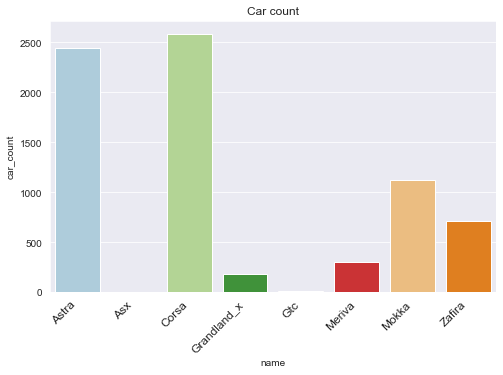

In [62]:
plot_bar_chart(car_count,'name','car_count',
                title='Car count',
                figsize=(8,5),
                palette='Paired')

Car type Max prices

In [63]:
cars_max_price = cars.groupby('name')['price'].max().reset_index()
cars_max_price

,name,price
0,Astra,20542
1,Asx,5995
2,Corsa,26100
3,Grandland_x,28991
4,Gtc,21500
5,Meriva,10995
6,Mokka,31500
7,Zafira,16479


Car type Max owners

In [64]:
cars_max_owners = cars.groupby('name')['owners'].mean().reset_index()
cars_max_owners


,name,owners
0,Astra,2.858838
1,Asx,2.000000
2,Corsa,2.813055
3,Grandland_x,2.153005
4,Gtc,2.666667
5,Meriva,3.086379
6,Mokka,2.336908
7,Zafira,2.693166


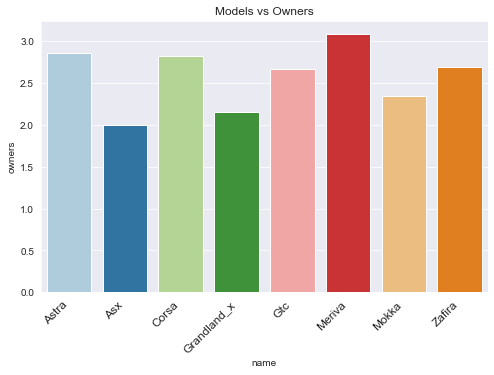

In [65]:
plot_bar_chart(cars_max_owners,
                'name','owners',
                title='Models vs Owners',
                figsize=(8,5),
                palette='Paired')

Fuel type  vs Price

In [66]:
fuel_type = cars.groupby('fuel')['price'].mean().reset_index()
#.max().sort_values('owners',ascending=False)
fuel_type.head()

,fuel,price
0,Diesel,6941.356051
1,Electric,25179.000000
2,Petrol,7133.311192
3,Petrol Plug-in Hybrid,27094.000000


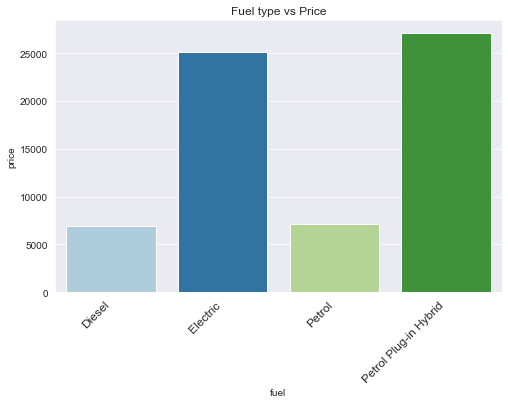

In [68]:
plot_bar_chart(fuel_type,'fuel','price',
                title='Fuel type vs Price',
                figsize=(8,5),
                palette='Paired')

Transmission vs Price

In [69]:
transmission = cars.groupby(['transmission'])['price'].mean().reset_index()
transmission

,transmission,price
0,Automatic,8689.832477
1,Manual,6884.920488


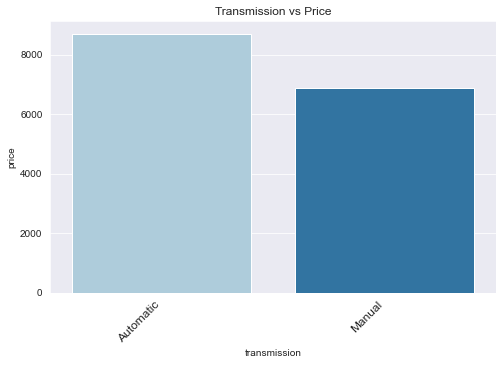

In [70]:


plot_bar_chart(transmission,'transmission','price',
                title='Transmission vs Price',
                figsize=(8,5),
                palette='Paired')

Transmission vs Price

<AxesSubplot:xlabel='year', ylabel='price'>

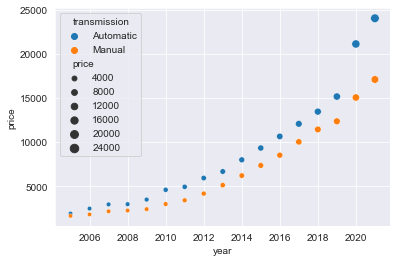

In [71]:
transmission_yearly_price = cars.groupby(['transmission','year'])['price'].mean().reset_index()
sns.set_style("darkgrid")
sns.scatterplot(data = transmission_yearly_price, x = 'year', y = "price", hue = "transmission",size='price')

ULEZ vs price

In [72]:
ulez_price = cars.groupby(['ULEZ','year'])['price'].mean().reset_index()
ulez_price.head()

,ULEZ,year,price
0,No,2005.0,1670.000000
1,No,2006.0,1593.166667
2,No,2007.0,1934.500000
3,No,2008.0,2098.536585
4,No,2009.0,2303.300000


<AxesSubplot:xlabel='year', ylabel='price'>

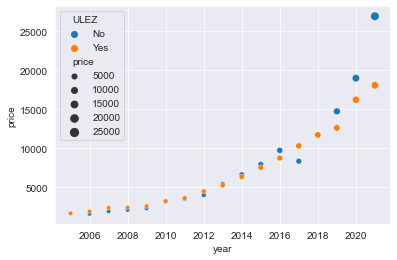

In [73]:
sns.scatterplot(data = ulez_price, x = 'year', y = "price", hue = "ULEZ",size='price')

In [74]:
cars['ULEZ'].value_counts().reset_index()

,index,ULEZ
0,Yes,6402
1,No,961


Car Engine vs Price

In [78]:
# car engine vs price for corsa and grandland x
cars_engine_price = cars_filtered.groupby(['name','engine'])['price'].mean().reset_index()
cars_engine_price

,name,engine,price
0,Corsa,1.0,4222.251572
1,Corsa,1.2,5409.971719
2,Corsa,1.3,3786.186992
3,Corsa,1.4,7001.032774
4,Corsa,1.5,15879.333333
5,Corsa,1.6,7065.043956
6,Corsa,1.7,3179.888889
7,Grandland_x,1.2,16616.727273
8,Grandland_x,1.5,15791.485714
9,Grandland_x,1.6,17586.481481


<AxesSubplot:xlabel='engine', ylabel='price'>

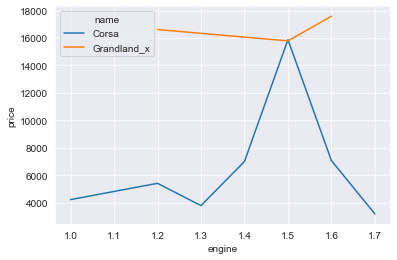

In [79]:
sns.lineplot(data = cars_engine_price, x = 'engine', y = "price", hue = "name")

In [34]:
BHP=cars.groupby(['name','engine'])[['BHP']].agg(pd.Series.mode).sort_values('BHP', ascending = False).reset_index()


BHP.head()

,name,engine,BHP
0,Corsa,1.4,99.0
1,Corsa,1.2,84.0
2,Corsa,1.3,74.0
3,Corsa,1.0,64.0
4,Corsa,1.5,[]


Rename columns

In [35]:
col_rename_dict={
    'name':'model'
}

cars.rename(columns=col_rename_dict, inplace=True)  
cars.head()


,model,price,mileage,BHP,transmission,fuel,owners,body,ULEZ,engine,year
0,Astra,995,85405.0,103.0,Manual,Petrol,4,Hatchback,Yes,1.6,2005.0
1,Astra,1350,84000.0,103.0,Manual,Petrol,3,Hatchback,Yes,1.6,2005.0
4,Astra,1695,64000.0,123.0,Automatic,Petrol,5,Estate,Yes,1.8,2005.0
5,Astra,1649,96793.0,123.0,Automatic,Petrol,5,Estate,Yes,1.8,2005.0
6,Astra,880,127101.0,103.0,Automatic,Petrol,5,Hatchback,Yes,1.6,2005.0


In [36]:
cars.to_csv('data/cars_used.csv')


In [37]:
cars.describe()

,price,mileage,BHP,owners,engine,year
count,7363.000000,7361.000000,3681.000000,7363.000000,7348.000000,7259.000000
mean,7123.351759,58817.926369,113.212986,2.738693,1.477436,2013.980576
std,3959.850004,30957.018953,32.507303,1.129802,0.222805,3.387817
min,495.000000,32.000000,59.000000,2.000000,1.000000,2005.000000
25%,3990.000000,34835.000000,89.000000,2.000000,1.400000,2012.000000
50%,6750.000000,55002.000000,113.000000,2.000000,1.400000,2014.000000
75%,9595.000000,80000.000000,134.000000,3.000000,1.600000,2016.000000
max,31500.000000,204000.000000,276.000000,15.000000,2.200000,2021.000000


### Plot Correlation

In [38]:
def plot_correlation(corr):



    plt.figure(figsize = (6,6)) # setting the size of the output

    sns.heatmap(corr,
                annot = True,
                linecolor='black',
                center=0,
                vmin=-1,
                vmax=1,
                cmap = sns.diverging_palette(600,600, as_cmap=True),
                fmt='.4g')

    plt.title('Car features and thier correlation') # naming the plot

    #plt.savefig('plot.png', dpi = 300, bbox_inches = 'tight') # saving the chart as a .png – it will be saved in the current working directory

    plt.show()

In [39]:
cars_corr = cars.corr()
cars_corr

,price,mileage,BHP,owners,engine,year
price,1.000000,-0.734103,0.441919,-0.384629,-0.090474,0.834424
mileage,-0.734103,1.000000,-0.046614,0.332690,0.250889,-0.637146
BHP,0.441919,-0.046614,1.000000,0.012113,0.725255,0.187160
owners,-0.384629,0.332690,0.012113,1.000000,0.072791,-0.433070
engine,-0.090474,0.250889,0.725255,0.072791,1.000000,-0.193596
year,0.834424,-0.637146,0.187160,-0.433070,-0.193596,1.000000


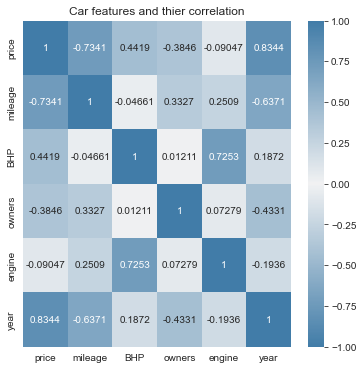

In [40]:
plot_correlation(cars_corr)

Pairplot

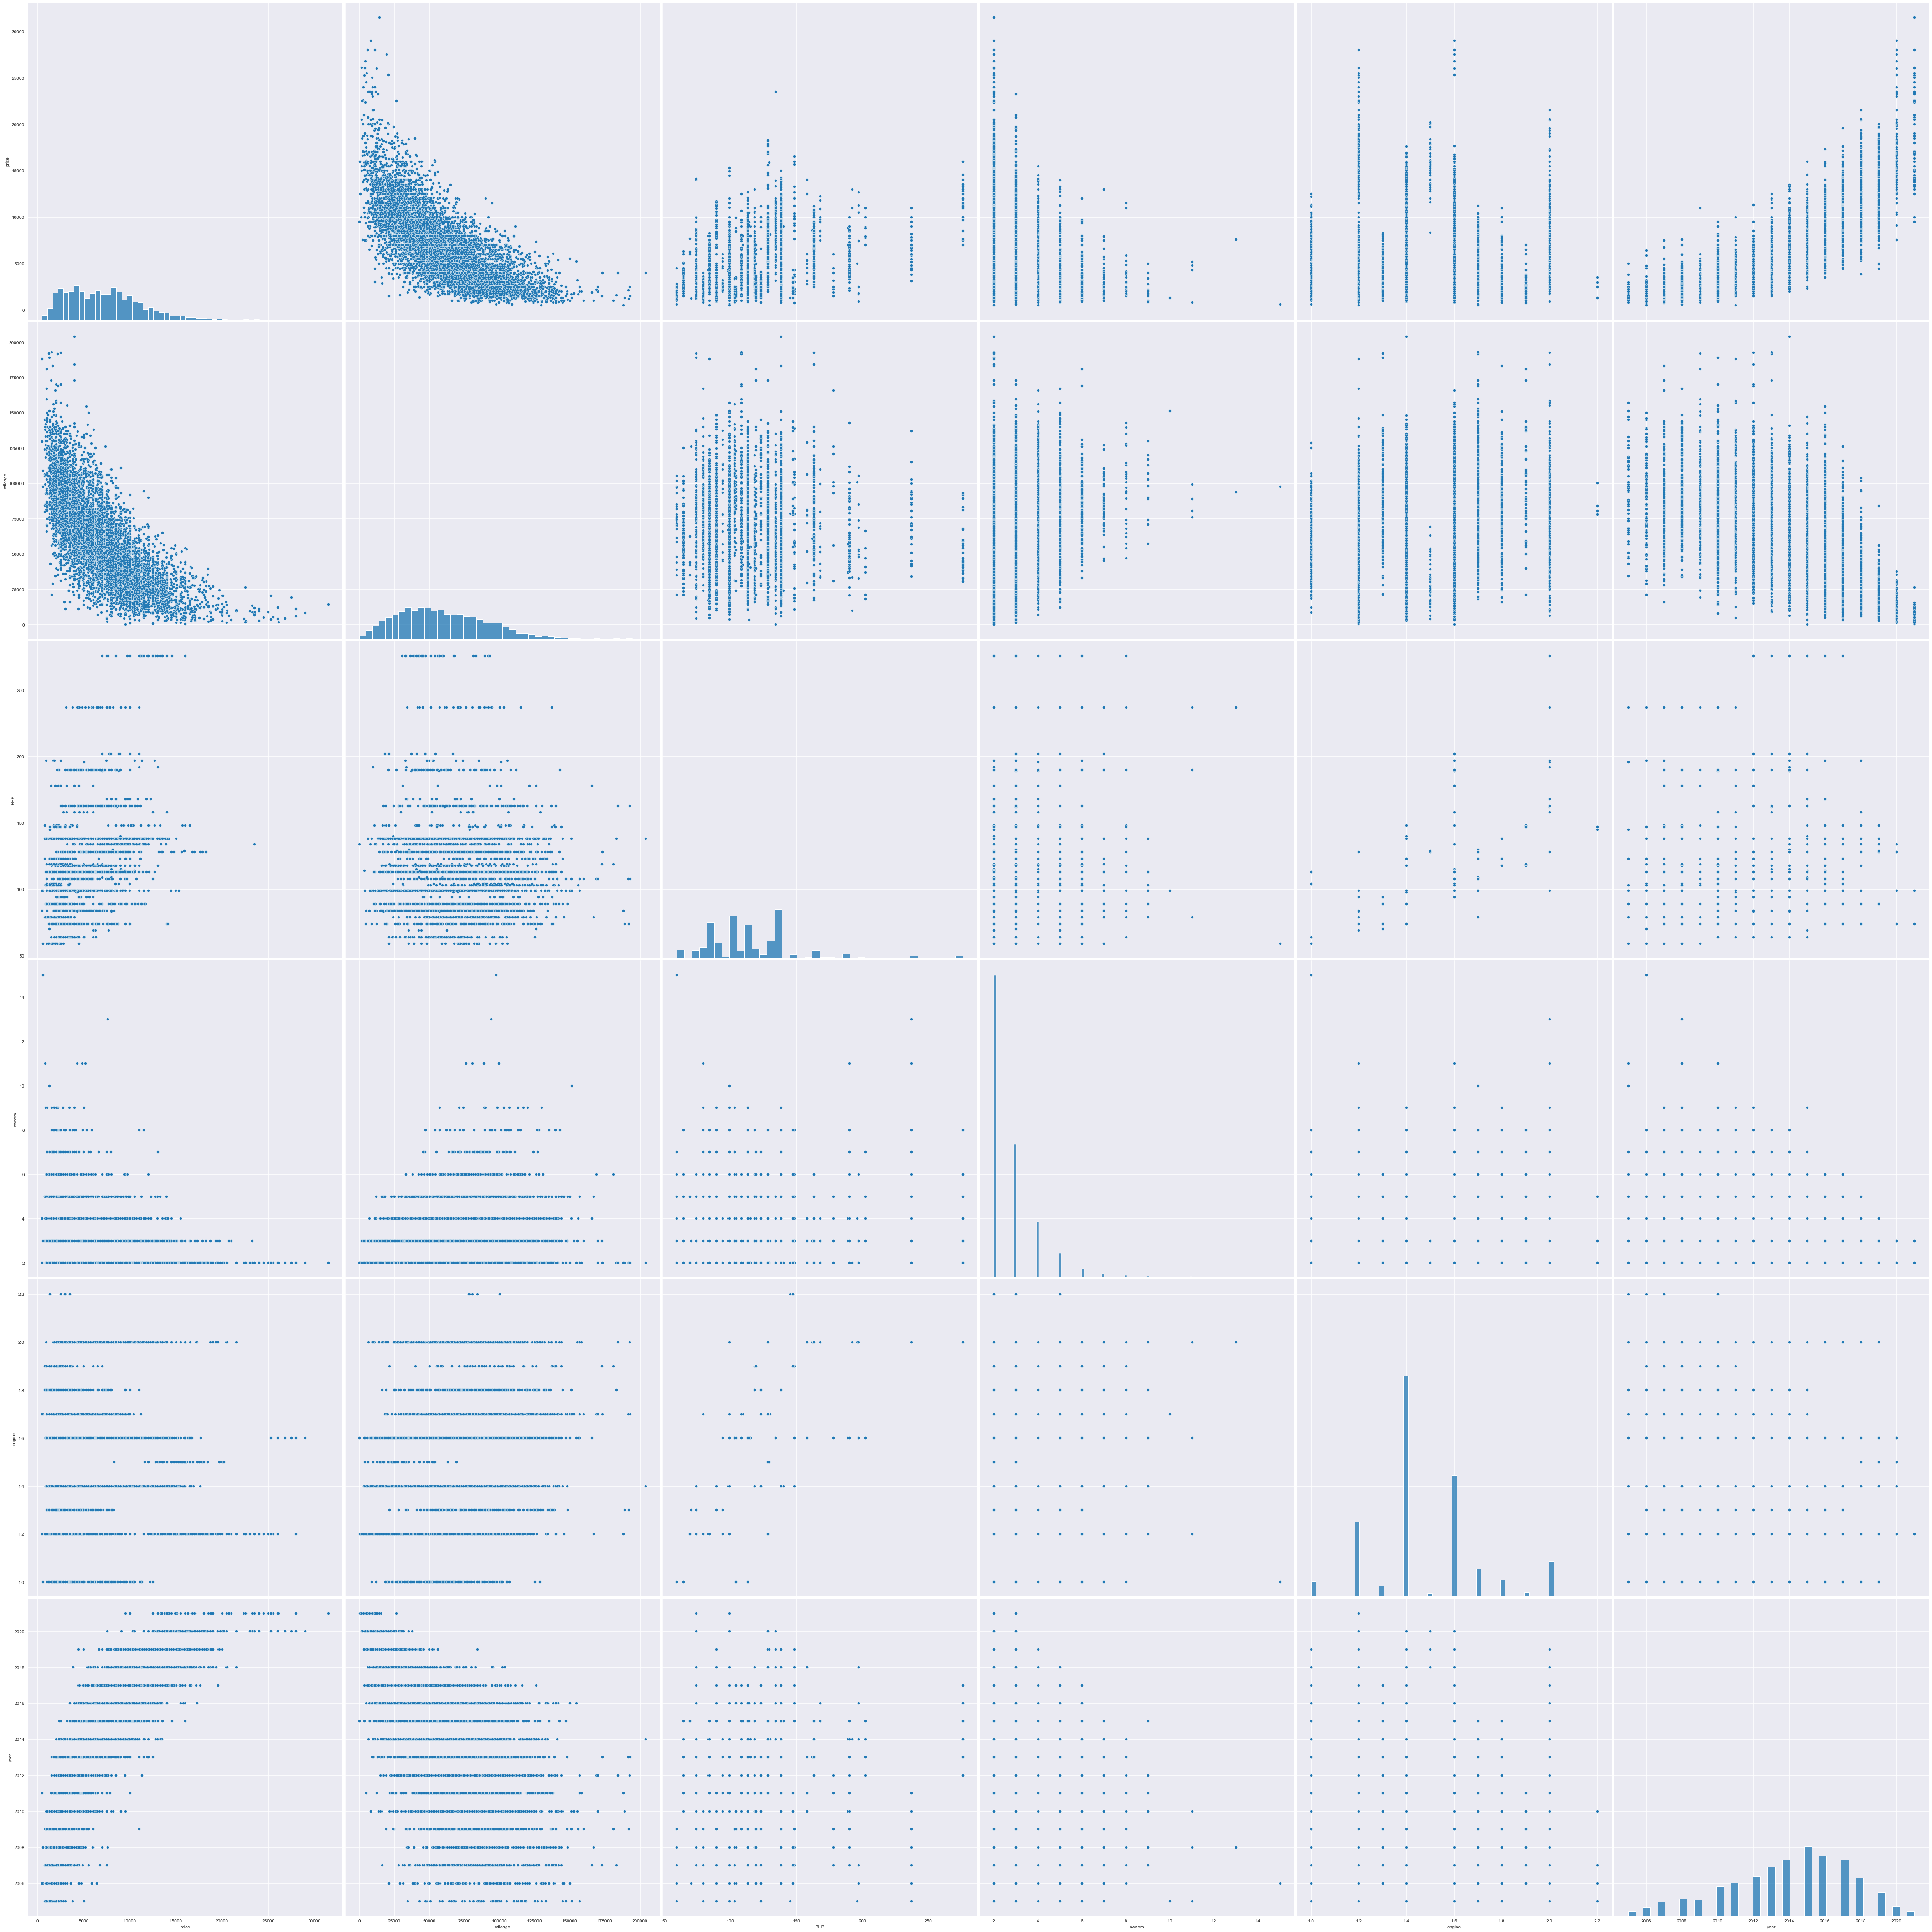

In [41]:
sns.pairplot(cars, height = 10)
plt.show()

In [42]:
cars.isnull().sum()

model              0
price              0
mileage            2
BHP             3682
transmission       1
fuel               0
owners             0
body               0
ULEZ               0
engine            15
year             104
dtype: int64